## Getting torsion barrier heights from QCA TorsionDrive datasets

### Things working now:
 - Takes in torsiondrive dataset name and specification as input and outputs a list of 
     (tdr_object.id, 
     dihedral_indices, 
     torsion_barrier,
     oemol_object) for all the completed runs in the torsiondrive
 - <u> Torsion barrier calculation:</u> A check is performed to look for sign change in the derivatives, which gives us the maxima and minima, and the original data is padded front and back with the angles translated by (2*pi) for last three and first three terms so that these differences would include the end point maxima or minima. Highest barrier is returned as the overall torsion barrier since it is rate-limiting. 
 - <u> WBO value:</u> is not calculated from the QM data since a separate ELF10-AM1 evaluation is done using the oemol objects. ELF10-AM1 is supposed to be independent of conformations.

### Things to do/in progress:
 - def checkTorsion(tID, ff, mol)


In [6]:
import time
import qcportal as ptl
import numpy as np
import matplotlib.pyplot as plt
from fragmenter.utils import HARTREE_2_KJMOL
from simtk import unit
import os, sys
from fragmenter import chemi

    
def torsion_barrier_for_molecule(tdr_object, smiles, show_plots=False):
    """
    Takes in a single torsion drive record that has energies from multiple conformers (at different torsion angles), evaluates the torsion barrier 
    
    Parameters
    ----------
    tdr_object : object
        torsion drive record from QC archive for a molecule
    
    Returns
    -------
    tdr_object.id : int
        id of the TD record
    dihedral_indices: list
        list of atom indices for which torsion is driven in this record
    torsion_barrier: float
        torsion barrier energy in KJ/mol, maximum of all the barriers
    mol: oemol object
        oemol from the smiles in dataframe index
    """
    energies = list(tdr_object.get_final_energies().values())
    tmp = list(tdr_object.get_final_energies().keys())
    angles = [i[0]*np.pi/180 for i in tmp]
    angles, energies = zip(*sorted(zip(angles, energies)))
    angles = np.array(angles)
    energies = np.array(energies)
    angles = np.append(angles[-3:] - 2*np.pi, np.append(angles, angles[:3] + 2*np.pi))
    energies = np.append(energies[-3:], np.append(energies, energies[:3]))
    
    idx = []
    for i in range(len(angles)-2):
        m1 = (energies[i+1]-energies[i])/(angles[i+1]-angles[i])
        m2 = (energies[i+2]-energies[i+1])/(angles[i+2]-angles[i+1])
        if np.sign(m1) == np.sign(m2):
            continue
        else:
            idx.append(i+1)
        
    if (show_plots):
        min_ener = min(energies)
        energies_y = (energies-min_ener)*HARTREE_2_KJMOL
        fontsize = 14
        plt.figure()
        plt.plot(angles*180/np.pi, energies_y, 'b-X', angles[idx]*180/np.pi, energies_y[idx], 'ro')
        plt.legend(['QM data', 'Max, min'], bbox_to_anchor=(1, 1), fontsize=fontsize)
        plt.title('Torsion drive interpolation', fontsize=fontsize)
        plt.xlabel('Dihedral Angle [Degrees]', fontsize=fontsize)
        plt.ylabel('Relative energy [KJ / mol]', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        fig_name = 'plot_' + tdr_object.id + '.png'
        plt.savefig(fig_name)
        plt.show()
        
    torsion_barriers = []
    for i in range(int(len(idx)-1)):
        torsion_barriers.append(abs(HARTREE_2_KJMOL*abs(energies[idx[i]] - energies[idx[i+1]])))
    torsion_barriers = np.array(torsion_barriers)
    
    # get dihedral indices and pass on to get_wbo function
    dihedral_indices = list(tdr_object.dict()['keywords']['dihedrals'][0])
    mol = chemi.smiles_to_oemol(smiles)
    return(tdr_object.id, dihedral_indices, max(torsion_barriers), mol)

def loadDataset(datasets):
    """
        To load torsion drive datasets and return a list of molecules with torsion barriers and associated wiberg bond order
        
        Parameters
        ----------
        datasets : list of tuples containing the dataset name and specification
        
        Returns
        -------
        molList : each row contains the tdr_object.id, oemol_object, dihedral_indices, torsion_barrier, wbo
    """
    molList = []
    for dataset_tuple in datasets:
        print("Reading dataset: ", dataset_tuple[0], ", and specification: ", dataset_tuple[1])
        molList.extend(loadDataset_low(dataset_tuple[0], dataset_tuple[1]))

    return molList

def loadDataset_low(datasetName, specification):
    """
    Low level call to load each torsion drive dataset and return a list of molecules
    
        Parameters
        ----------
        datasetName : str
            torsion drive dataset name.  
        specification : str
            specification in the dataset. Example: "B3LYP-D3", "default", "UFF" 
        
        Returns
        -------
        molList : list of objects
            each row contains the tdr_object.id, dihedral_indices, torsion_barrier, oemol_object
    """
    while True:    
        try:
            assert(datasetName)
            break
        except AssertionError:
            print ("datasetName is empty. Check input list of dataset tuples")
            raise
    while True:    
        try:
            assert(specification)
            break
        except AssertionError:
            print ("specification is empty. Check input list of dataset tuples")
            raise

    # initiate qc portal instance
    client = ptl.FractalClient()    
    # from the TorsionDriveDataset collection picking up given datasetName
    ds = client.get_collection("TorsionDriveDataset", datasetName)
    ds.status([specification], status="COMPLETE")
 
    # Serial implementation
    tb = []
    for i in range(ds.df.size):
        if (ds.df.iloc[i,0].status == 'COMPLETE'):
            tb.append(torsion_barrier_for_molecule(ds.df.iloc[i, 0], ds.df.index[i]))
    print("Total records processed for this dataset:", len(tb), "out of ", len(ds.df))
    return(tb)


In [2]:
dataset_name = "OpenFF Gen 2 Torsion Set 5 Bayer"
specification = "default"
set_tuple = (dataset_name, specification)

In [3]:
start = time.time()
#("OpenFF Fragmenter Phenyl Benchmark", "B3LYP-D3")
tb_list = loadDataset([set_tuple, ("OpenFF Fragmenter Phenyl Benchmark", "B3LYP-D3")])
end = time.time()
print("time elapsed: ", end - start)

Reading dataset:  OpenFF Gen 2 Torsion Set 5 Bayer , and specification:  default
Total records processed for this dataset: 77 out of  100
Reading dataset:  OpenFF Fragmenter Phenyl Benchmark , and specification:  B3LYP-D3
Total records processed for this dataset: 226 out of  227
time elapsed:  4.994531154632568


In [4]:
tb_list[0]

('18045851',
 [10, 14, 15, 22],
 51.774638032995426,
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f43545a9150> >)

In [5]:
len(tb_list)

303

## For first few molecules in the dataset, torsion barriers

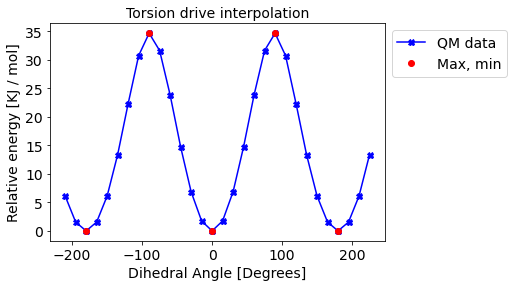

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761822', [3, 5, 6, 7], 34.64509060977903, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13de91f630> >)


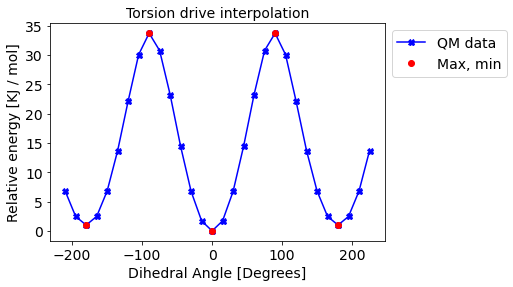

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761823', [1, 4, 5, 7], 33.71470942817902, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13df737d80> >)


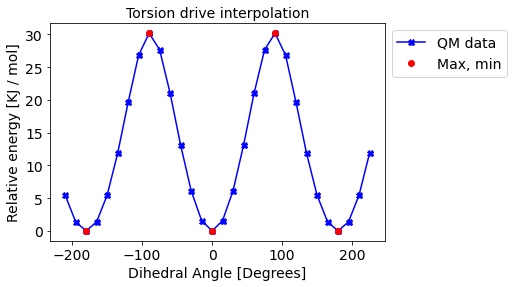

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761824', [0, 4, 5, 7], 30.17980050481978, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e041ed20> >)


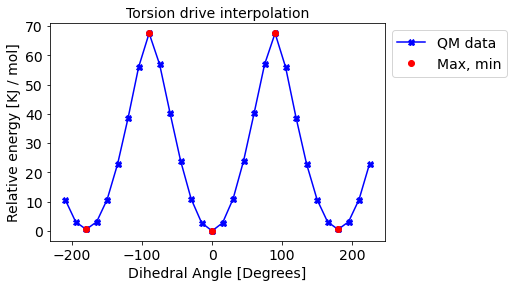

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761825', [0, 3, 5, 8], 67.51672823526388, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e0384c00> >)


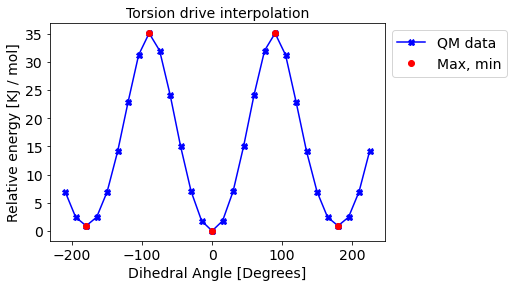

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761826', [0, 3, 5, 8], 35.06939665729763, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e46d27b0> >)


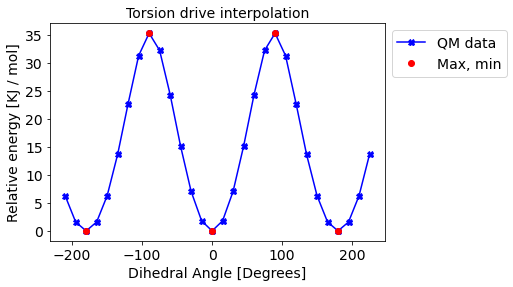

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761827', [0, 4, 6, 7], 35.26417697113038, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e0bf1450> >)


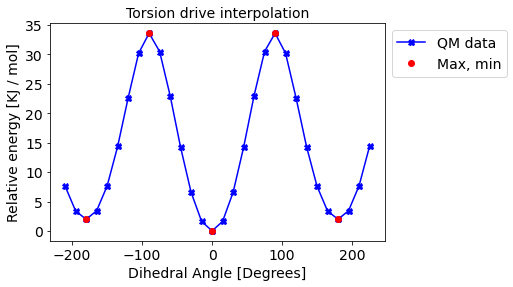

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761828', [0, 3, 5, 8], 33.603336550205995, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e0beb810> >)


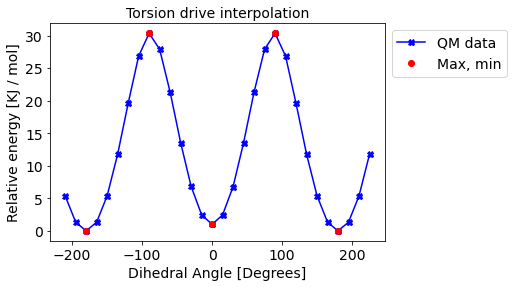

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761829', [0, 3, 5, 9], 30.362479610289938, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e47bbf60> >)


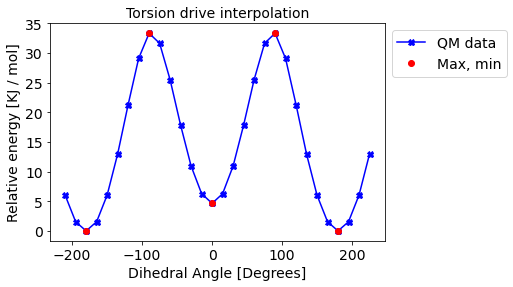

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761830', [0, 3, 5, 11], 33.334678189134024, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13de62d8d0> >)


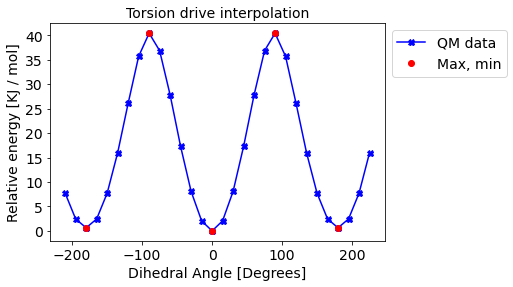

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761831', [0, 3, 5, 11], 40.394951518082564, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e115a7e0> >)


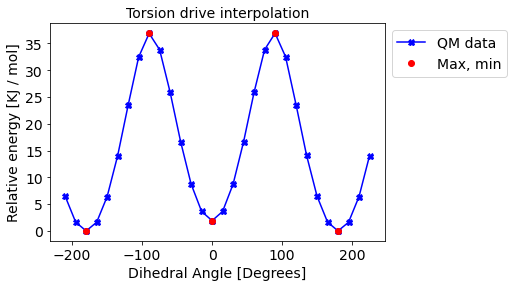

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761832', [1, 4, 6, 12], 36.91215478301393, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e1188840> >)


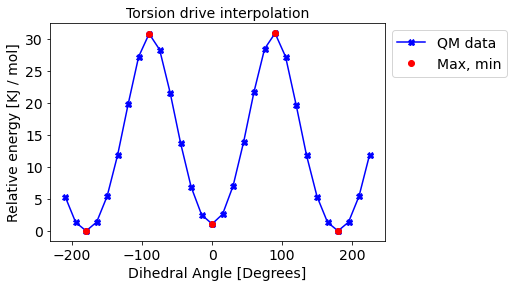

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761833', [0, 3, 5, 12], 30.84009139007503, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e0420210> >)


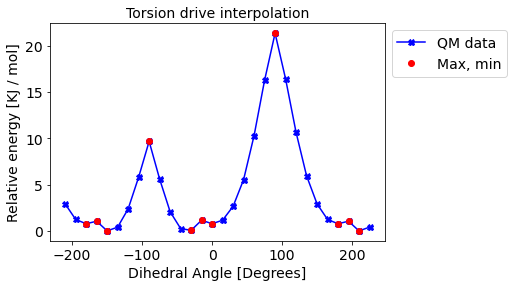

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761834', [3, 5, 8, 6], 20.567217576146362, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e11fcc00> >)


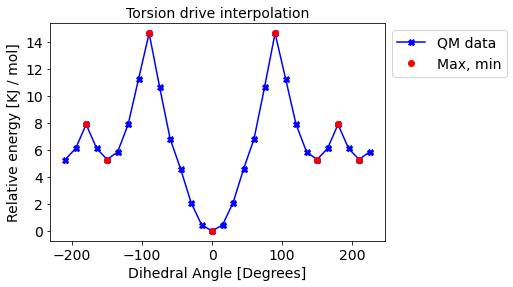

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761835', [1, 4, 8, 5], 14.656296073109559, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e112d210> >)


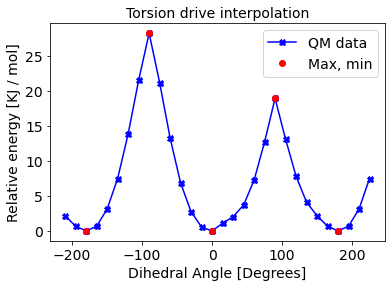

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761836', [0, 4, 8, 5], 28.260448520371938, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e476cf90> >)


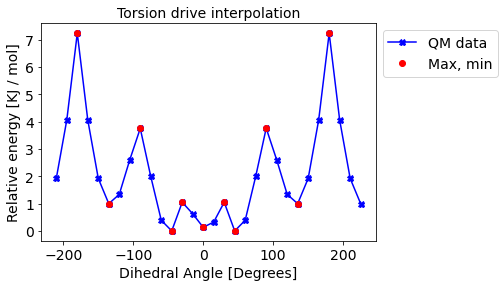

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761837', [0, 3, 9, 5], 6.242000776156885, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e0bb24e0> >)


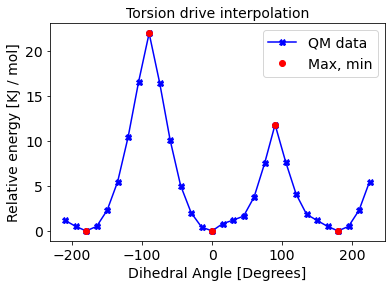

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761838', [0, 4, 8, 6], 21.92603780494119, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e0b24f90> >)


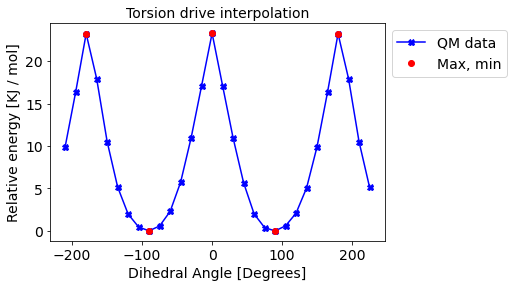

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761839', [0, 4, 8, 6], 23.281954580375896, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13de6047e0> >)


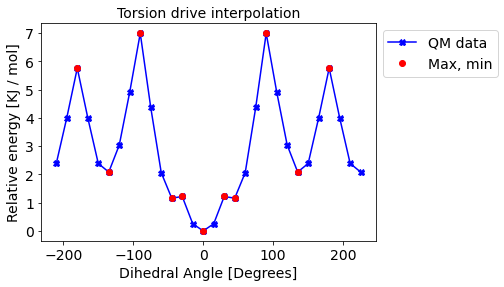

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761840', [0, 3, 9, 5], 5.837363730278355, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13de54e930> >)


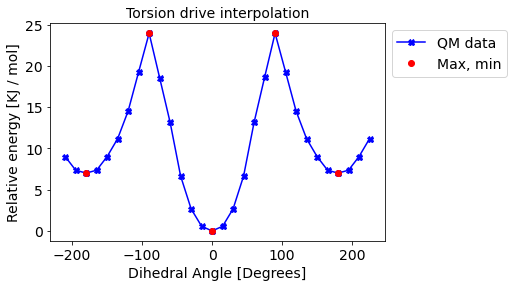

Torsion Id, Dihedral_indices, Torsion barrier, oemol
('1761841', [2, 5, 10, 6], 23.944035670707876, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13de4da540> >)


In [7]:
client = ptl.FractalClient()
ds = client.get_collection("TorsionDriveDataset", "OpenFF Fragmenter Phenyl Benchmark")
ds.status("B3LYP-D3", status="COMPLETE")
for i in range(20):
    output = torsion_barrier_for_molecule(ds.df.iloc[i, 0], ds.df.index[i], True)
    print("Torsion Id, Dihedral_indices, Torsion barrier, oemol")
    print(output)



## Minimal example to get the 'tid' and 'smarts' from a molecule's torsiondrive in a dataset

In [13]:
import qcportal as ptl
from openeye import oechem
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
import cmiles

client = ptl.FractalClient()
ds = client.get_collection("TorsionDriveDataset", "OpenFF Fragmenter Phenyl Benchmark")
ds.status("B3LYP-D3", status="COMPLETE")
output = torsion_barrier_for_molecule(ds.df.iloc[1, 0], ds.df.index[1])
print("Torsionderive record Id, Dihedral_indices, Torsion barrier, oemol")
print(output)
dihedral_indices = ds.df.iloc[1, 0].dict()['keywords']['dihedrals'][0]
print("Dihedral indices for which torsion is driven: ", dihedral_indices)

smiles = ds.df.index[1]
molecule = Molecule.from_qcschema(ds.get_entry(smiles))
topology = Topology.from_molecules([molecule])

# Let's label using the Parsley force field
forcefield = ForceField('openff-1.2.1.offxml')

# Run the molecule labeling
molecule_force_list = forcefield.label_molecules(topology)

# Print out a formatted description of the torsion parameters applied to this molecule
for mol_idx, mol_forces in enumerate(molecule_force_list):
    print(f'Forces for molecule {mol_idx}')
    for force_tag, force_dict in mol_forces.items():
        if force_tag == 'ProperTorsions':
            print(f"\n{force_tag}:")
            for (atom_indices, parameter) in force_dict.items():
                if(atom_indices == dihedral_indices):
                    atomstr=''
                    for idx in atom_indices:
                        atomstr += '%3s' % idx
                    print("atoms: %s  parameter_id: %s  smirks %s" % (atomstr, parameter.id, parameter.smirks) )


Torsionderive record Id, Dihedral_indices, Torsion barrier, oemol
('1761823', [1, 4, 5, 7], 33.71470942817902, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13df484ed0> >)
Dihedral indices for which torsion is driven:  (1, 4, 5, 7)
Forces for molecule 0

ProperTorsions:
atoms:   1  4  5  7  parameter_id: t47  smirks [*:1]~[#6X3:2]-[#6X3$(*=[#8,#16,#7]):3]~[*:4]


In [4]:
import qcportal as ptl
from openeye import oechem
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
import cmiles

client = ptl.FractalClient()
ds = client.get_collection("TorsionDriveDataset", "OpenFF Rowley Biaryl v1.0")
ds.status("default", status="COMPLETE")
output = torsion_barrier_for_molecule(ds.df.iloc[1, 0], ds.df.index[1])
print("Torsionderive record Id, Dihedral_indices, Torsion barrier, oemol")
print(output)
dihedral_indices = ds.df.iloc[1, 0].dict()['keywords']['dihedrals'][0]
print("Dihedral indices for which torsion is driven: ", dihedral_indices)

smiles = ds.df.index[1]
cmiles_ids = cmiles.get_molecule_ids(smiles, strict=False)
mapped_smiles = cmiles_ids['canonical_isomeric_explicit_hydrogen_mapped_smiles']
molecule = Molecule.from_mapped_smiles(mapped_smiles)
topology = Topology.from_molecules([molecule])

# Let's label using the Parsley force field
forcefield = ForceField('openff-1.2.1.offxml')

# Run the molecule labeling
molecule_force_list = forcefield.label_molecules(topology)

# Print out a formatted description of the torsion parameters applied to this molecule
for mol_idx, mol_forces in enumerate(molecule_force_list):
    print(f'Forces for molecule {mol_idx}')
    for force_tag, force_dict in mol_forces.items():
        if force_tag == 'ProperTorsions':
            print(f"\n{force_tag}:")
            for (atom_indices, parameter) in force_dict.items():
                if(atom_indices == dihedral_indices):
                    atomstr=''
                    for idx in atom_indices:
                        atomstr += '%3s' % idx
                    print("atoms: %s  parameter_id: %s  smirks %s" % (atomstr, parameter.id, parameter.smirks) )


Torsionderive record Id, Dihedral_indices, Torsion barrier, oemol
('21272353', [3, 5, 10, 8], 7.828225770921421, <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f13e4b65e70> >)
Dihedral indices for which torsion is driven:  (3, 5, 10, 8)
Forces for molecule 0

ProperTorsions:
